# Análises

In [1]:
!pip install wget
!pip install unzip

/bin/pip:6: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import load_entry_point
/usr/share/python-wheels/toml-0.10.0-py2.py3-none-any.whl/toml/decoder.py:47: SyntaxWarning: invalid escape sequence '\.'
/usr/share/python-wheels/toml-0.10.0-py2.py3-none-any.whl/toml/decoder.py:47: SyntaxWarning: invalid escape sequence '\.'
Traceback (most recent call last):
  File "/bin/pip", line 11, in <module>
    load_entry_point('pip==20.0.2', 'console_scripts', 'pip')()
  File "/usr/lib/python3/dist-packages/pip/_internal/cli/main.py", line 73, in main
    command = create_command(cmd_name, isolated=("--isolated" in cmd_args))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3/dist-packages/pip/_internal/commands/__init__.py", line 96, in create_command
    module = importlib.import_module(module_path)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  

In [2]:
! wget https://github.com/MarialuizaLeao/tp_geo/blob/main/MA_Municipios_2023.zip
! wget https://github.com/MarialuizaLeao/tp_geo/tree/main/MA_regioes_intermediarias.zip
! wget https://github.com/MarialuizaLeao/tp_geo/blob/main/demografia_MA.csv
! wget https://github.com/MarialuizaLeao/tp_geo/blob/main/perfil_eleitor_agregado.csv
! wget https://github.com/MarialuizaLeao/tp_geo/blob/main/deputados_agg_municipio.zip
! wget https://github.com/MarialuizaLeao/tp_geo/blob/main/nota_fiscal_candidato_2022_MA.csv

--2025-01-13 23:34:57--  https://github.com/MarialuizaLeao/tp_geo/blob/main/MA_Municipios_2023.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘MA_Municipios_2023.zip.1’

MA_Municipios_2023.     [     <=>            ] 221.41K   135KB/s    in 1.6s    

2025-01-13 23:35:02 (135 KB/s) - ‘MA_Municipios_2023.zip.1’ saved [226719]

--2025-01-13 23:35:03--  https://github.com/MarialuizaLeao/tp_geo/tree/main/MA_regioes_intermediarias.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/MarialuizaLeao/tp_geo/blob/main/MA_regioes_intermediarias.zip [following]
--2025-01-13 23:35:04--  https://github.com/MarialuizaLeao/tp_geo/blob/main/MA_regioes_intermediarias.zip
Reusing e

In [3]:
! unzip /content/deputados_agg_municipio.zip
! unzip /content/MA_Municipios_2023.zip
! unzip /content/deputados_agg_municipio.zip

unzip:  cannot find or open /content/deputados_agg_municipio.zip, /content/deputados_agg_municipio.zip.zip or /content/deputados_agg_municipio.zip.ZIP.
unzip:  cannot find or open /content/MA_Municipios_2023.zip, /content/MA_Municipios_2023.zip.zip or /content/MA_Municipios_2023.zip.ZIP.
unzip:  cannot find or open /content/deputados_agg_municipio.zip, /content/deputados_agg_municipio.zip.zip or /content/deputados_agg_municipio.zip.ZIP.


In [4]:
import geopandas as gpd
import pandas as pd
import sqlite3
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [6]:
perfil_eleitor = pd.read_csv('perfil_eleitor_agregado.csv', sep=',', encoding='utf-8')
demografia = pd.read_csv('demografia_MA.csv', sep=',', encoding='utf-8')
votacao_mun = gpd.read_file('deputados_agg_municipio/deputados_agg_municipio.shp')
regioes_MA = gpd.read_file('MA_regioes_intermediarias/MA_RG_Intermediarias_2023.shp')

In [7]:
votacao_mun.columns

Index(['CD_REGIAO', 'NM_REGIAO', 'CD_UF', 'NM_UF', 'CD_MUN', 'NM_MUN',
       'CD_DIST', 'NM_DIST', 'CD_RGINT', 'NM_RGINT', 'CD_RGI', 'NM_RGI',
       'CD_CONCURB', 'NM_CONCURB', 'AREA_KM2', 'v0001', 'v0002', 'v0003',
       'v0004', 'v0005', 'v0006', 'v0007', 'CD_MUNICIP', 'NM_MUNICIP',
       'NR_VOTAVEL', 'NM_VOTAVEL', 'Total_Voto', 'geometry'],
      dtype='object')

## Autocorrelação espacial

Os 10 candidatos mais votados das eleições de 2022 para os cargos de Deputado Estadual, Deputado Federal e Senador no estado do Maranhão, são:

In [8]:
votacao_mun_copy = votacao_mun.copy()

In [9]:
# drop VOTO NULO and VOTO BRANCO and VOTO ANULADO
votacao_mun_copy = votacao_mun_copy[(votacao_mun_copy.duplicated(subset=['CD_MUN', 'NR_VOTAVEL'], keep='first') == False)]
votacao_mun_copy = votacao_mun_copy[votacao_mun_copy['NR_VOTAVEL'] != 96]
votacao_mun_copy = votacao_mun_copy[votacao_mun_copy['NR_VOTAVEL'] != 96]
votacao_mun_copy = votacao_mun_copy[votacao_mun_copy['NR_VOTAVEL'] != 97]

In [10]:
top10_deputados_mais_votados = votacao_mun_copy.groupby('NM_VOTAVEL')['Total_Voto'].sum().sort_values(ascending=False).head(10)
top10_deputados_mais_votados

NM_VOTAVEL
MARIA DEUSDETE LIMA CUNHA RODRIGUES        161206
PEDRO LUCAS ANDRADE FERNANDES RIBEIRO      159786
JOSIMAR CUNHA RODRIGUES                    158360
JOSÉ JUSCELINO DOS SANTOS REZENDE FILHO    142419
ANDRÉ LUIZ CARVALHO RIBEIRO                135078
VOTO BRANCO                                132888
ALUISIO GUIMARAES MENDES FILHO             126577
ANTONIO DA CRUZ FILGUEIRA NETO             116246
HILDELIS SILVA DUARTE JUNIOR               111019
AMANDA KELLY GENTIL GUIMARÃES ROSA         108699
Name: Total_Voto, dtype: int64

In [11]:
def get_number_of_votes_municipality(db, municipio):
    return db[db['NM_MUN'] == municipio]['Total_Voto'].sum()

In [12]:
# GroupBy candidate and municipality and sum votes
candidatos_municipio = votacao_mun_copy.groupby(['NM_VOTAVEL', 'NM_MUN'])['Total_Voto'].sum().sort_values(ascending=False)

# GroupBy candidate and municipality with the most votes
candidatos_municipio = candidatos_municipio.reset_index().groupby('NM_VOTAVEL').first()

# Add column with the total number of votes for each candidate
candidatos_municipio['TOTAL_VOTOS'] = votacao_mun_copy.groupby('NM_VOTAVEL')['Total_Voto'].sum()

# Add column with the percentage of votes from the municipality
candidatos_municipio['PERCENTUAL_VOTOS_CANDIDATO'] = candidatos_municipio['Total_Voto'] / candidatos_municipio['TOTAL_VOTOS']

# Add column with the number of votes from the municipality in general
candidatos_municipio['TOTAL_VOTOS_MUNICIPIO'] = candidatos_municipio['NM_MUN'].apply(lambda x: get_number_of_votes_municipality(votacao_mun_copy, x))

Os candidatos ordenados pela porcentagem dos votos vindos de um só município. Foram filtrados apenas os candidatos que atingiram os votos necessários para ser eleito de acordo com o quociente eleitoral das eleições de 2022, para o cargo de Deputado Estadual. É possível perceber que muitos candidatos tem uma representatividade regional grande, não tendo votos em muitos municípios.

In [13]:
# Add column with the percentage of votes from the municipality in general
candidatos_municipio['PERCENTUAL_VOTOS_MUNICIPIO'] = candidatos_municipio['Total_Voto'] / candidatos_municipio['TOTAL_VOTOS_MUNICIPIO']

# Sort by PERCENTUAL_VOTOS_CANDIDATO
candidatos_municipio = candidatos_municipio.sort_values('PERCENTUAL_VOTOS_CANDIDATO', ascending=False)

# Filter candidates with over 7400 votes
QUOCIENTE_ELEITORAL = 50000
candidatos_municipio = candidatos_municipio[candidatos_municipio['TOTAL_VOTOS'] > QUOCIENTE_ELEITORAL/10]

candidatos_municipio

# Percentual_votos_municipio alto = candidato mt representativo no municipio

,NM_MUN,Total_Voto,TOTAL_VOTOS,PERCENTUAL_VOTOS_CANDIDATO,TOTAL_VOTOS_MUNICIPIO,PERCENTUAL_VOTOS_MUNICIPIO
NM_VOTAVEL,,,,,,
MAURO IVAN FARIAS DE SANTIAGO JUNIOR,SÃO LUÍS,6121,6647,0.920867,614189,0.009966
DANIEL PEREIRA BARROS,CAXIAS,8481,9381,0.904061,84717,0.100110
CELIO ALEX ALVES PAIVA,SÃO LUÍS,4676,5207,0.898022,614189,0.007613
HENRIQUE CESAR FERREIRA DE MELO LIMA JUNIOR,TIMON,17107,19450,0.879537,93503,0.182957
EDIMAR DE AGUIAR FRANCO,COROATÁ,8659,9853,0.878819,32567,0.265883
...,...,...,...,...,...,...
ANDRÉ LUIZ CARVALHO RIBEIRO,COELHO NETO,9524,135078,0.070507,24308,0.391805
JOSÉ CARLOS NUNES JÚNIOR,SÃO LUÍS,3649,57909,0.063013,614189,0.005941
WOLMER DE AZEVEDO ARAUJO,SÃO LUÍS,2255,43249,0.052140,614189,0.003672


In [14]:
# percentage of votes from the municipality SAO LUIS
votos_sao_luis = get_number_of_votes_municipality(votacao_mun_copy, 'SÃO LUÍS')
total_votos = votacao_mun_copy['Total_Voto'].sum()

votos_sao_luis / total_votos

0.15974661683273642

Os mapas indicam a distribuição geográfica dos votos dos quatro candidatos mais votados para Deputado Federal em 2022 no Maranhão. O colormap "Reds" reflete a intensidade de votos por município, sendo:

* Tons claros (bege) representam baixa votação.
* Tons escuros (vermelho intenso) indicam alta concentração de votos.

In [15]:
def plot_votes_by_candidate(candidato):
    gdf_candidato = votacao_mun_copy[votacao_mun_copy['NM_VOTAVEL'] == candidato]

    # Sum votes by municipality but maintain geometry
    gdf_candidato = gdf_candidato.dissolve(by='NM_MUN', aggfunc='sum')

    bins = [0, 500, 1000, 2000, 5000, 10000, 100000]
    gdf_candidato['Total_Voto'] = pd.cut(gdf_candidato['Total_Voto'], bins=bins, labels=bins[1:], include_lowest=True)

    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    gdf_candidato.plot(column='Total_Voto', cmap='Reds', ax=ax, legend=True, linewidth=0.5, edgecolor='black')
    ax.set_facecolor("black")
    plt.title(f'Votos do candidato {candidato}')
    plt.axis('off')
    plt.show()

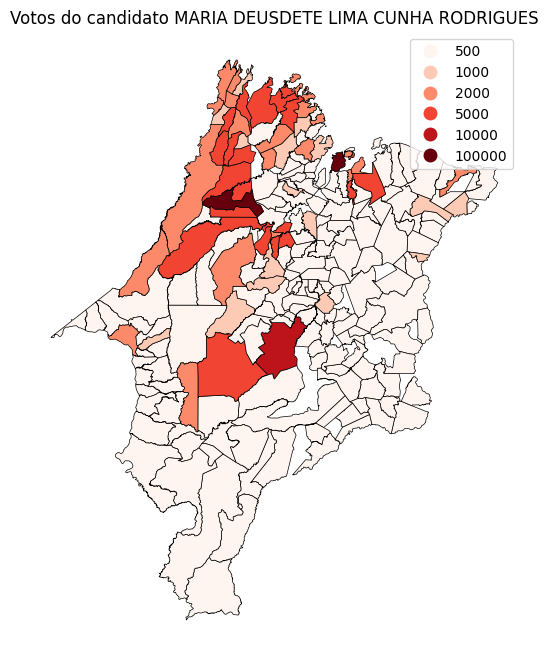

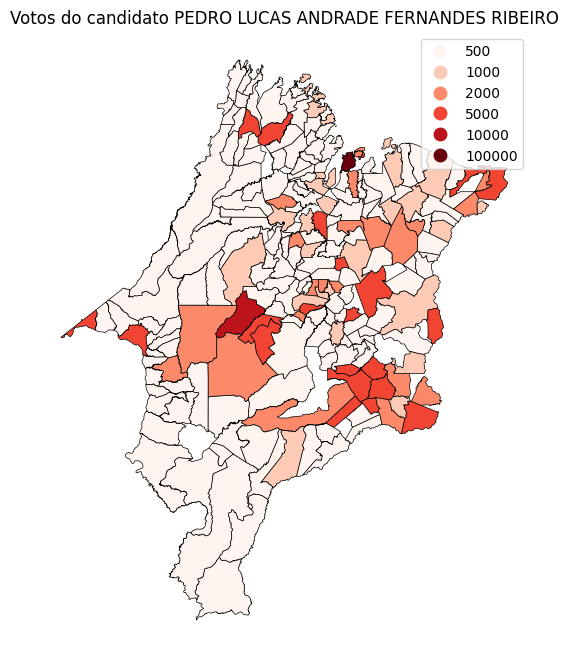

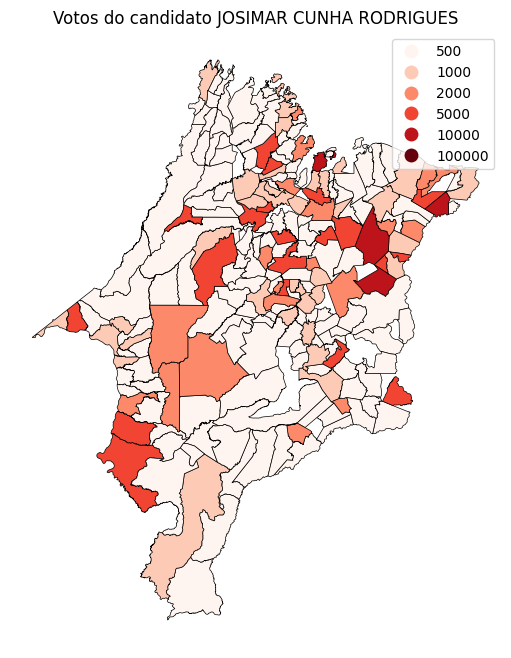

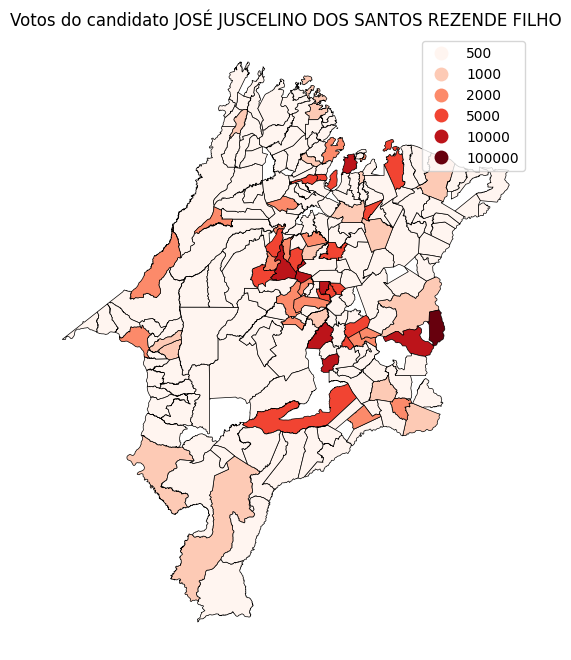

In [16]:
top_10_candidatos = votacao_mun_copy.groupby('NM_VOTAVEL')['Total_Voto'].sum().sort_values(ascending=False).head(4).index
for candidato in top_10_candidatos:
    plot_votes_by_candidate(candidato)

##### Candidato 1: MARIA DEUSDETE LIMA CUNHA RODRIGUES
* Foco Regional: A candidata teve alta concentração de votos em poucos municípios, com destaque em regiões no norte do estado.
* Distribuição: Seus votos estão relativamente espalhados pelo estado, mas não uniformemente. Algumas regiões têm representatividade mais significativa.

##### Candidato 2: PEDRO LUCAS ANDRADE FERNANDES RIBEIRO
* Foco Regional: O mapa mostra uma maior dispersão de votos, sugerindo que ele teve uma base eleitoral mais ampla e representativa em diferentes regiões.
* Hotspots: Alguns municípios no centro-sul e no leste do estado apresentam votos elevados.

##### Candidato 3: JOSIMAR CUNHA RODRIGUES
* Foco Regional: Apresenta votos distribuídos em todo o estado, mas com picos de concentração em municípios no extremo sul e em algumas partes do norte.
* Estratégia: A amplitude de sua distribuição sugere uma campanha com penetração ampla, mas com maior força em áreas específicas.

##### Candidato 4: JOSÉ JUSCELINO DOS SANTOS REZENDE FILHO
* Foco Regional: Forte concentração de votos em alguns municípios no centro do estado, além de algumas regiões do leste.
* Hotspots: Destaca-se pela intensidade de votos em algumas áreas específicas, indicando possíveis bases eleitorais estratégicas.

## Microrregiões


In [22]:

votacao_regiao = votacao_mun.copy()
votacao_regiao = votacao_regiao[(votacao_regiao.duplicated(subset=['CD_MUN', 'NR_VOTAVEL'], keep='first') == False)]
votacao_regiao = votacao_regiao[votacao_regiao['NM_VOTAVEL'] != 'VOTO NULO']
votacao_regiao = votacao_regiao[votacao_regiao['NM_VOTAVEL'] != 'VOTO BRANCO']
votacao_regiao = votacao_regiao.drop(columns='geometry')
votacao_regiao = pd.DataFrame(votacao_regiao).reset_index()
votacao_regiao.head()

,index,CD_REGIAO,NM_REGIAO,CD_UF,NM_UF,CD_MUN,NM_MUN,CD_DIST,NM_DIST,CD_RGINT,...,v0003,v0004,v0005,v0006,v0007,CD_MUNICIP,NM_MUNICIP,NR_VOTAVEL,NM_VOTAVEL,Total_Voto
0,0,2,Nordeste,21,Maranhão,2100055,AÇAILÂNDIA,210005505,Açailândia,2105,...,44339,31,"3,1","0,0477",34410,2100055,AÇAILÂNDIA,10,REPUBLICANOS,73
1,1,2,Nordeste,21,Maranhão,2100055,AÇAILÂNDIA,210005505,Açailândia,2105,...,44339,31,"3,1","0,0477",34410,2100055,AÇAILÂNDIA,11,PROGRESSISTAS,35
2,2,2,Nordeste,21,Maranhão,2100055,AÇAILÂNDIA,210005505,Açailândia,2105,...,44339,31,"3,1","0,0477",34410,2100055,AÇAILÂNDIA,12,Partido Democrático Trabalhista,92
3,3,2,Nordeste,21,Maranhão,2100055,AÇAILÂNDIA,210005505,Açailândia,2105,...,44339,31,"3,1","0,0477",34410,2100055,AÇAILÂNDIA,13,Partido dos Trabalhadores,275
4,4,2,Nordeste,21,Maranhão,2100055,AÇAILÂNDIA,210005505,Açailândia,2105,...,44339,31,"3,1","0,0477",34410,2100055,AÇAILÂNDIA,14,Partido Trabalhista Brasileiro,87


In [23]:
def get_total_habitants(db, col, value):
	return db[db[col] == int(value)]['Quantidade de moradores'].values[0]
votacao_regiao['TOTAL_HAB_MUN'] = votacao_regiao.apply(lambda x: get_total_habitants(demografia, 'CD_MUN', x['CD_MUN']), axis=1)


In [24]:
# List of regions
regions = regioes_MA['NM_RGINT'].unique().tolist()
print(regions)

hab_per_region = dict()
for region in regions:
    temp = votacao_regiao.copy()
    temp = temp[temp['NM_RGINT'] == region]
    mun = temp['CD_MUN'].unique().tolist()
    total = 0
    for m in mun:
        total = total + get_total_habitants(demografia, 'CD_MUN', m)
    hab_per_region[region] = total
print(hab_per_region)

['São Luís', 'Santa Inês - Bacabal', 'Caxias', 'Presidente Dutra', 'Imperatriz']
{'São Luís': 3145399, 'Santa Inês - Bacabal': 1173021, 'Caxias': 735054, 'Presidente Dutra': 456328, 'Imperatriz': 1255543}


In [25]:
votacao_regiao = votacao_regiao.groupby(['NM_RGINT','NM_VOTAVEL'])['Total_Voto'].sum().reset_index().sort_values('Total_Voto', ascending=False)
votacao_regiao = votacao_regiao.merge(regioes_MA, left_on='NM_RGINT', right_on='NM_RGINT', how='left')
votacao_regiao = gpd.GeoDataFrame(votacao_regiao)
votacao_regiao['TOTAL_HAB_REG'] = votacao_regiao.apply(lambda x: hab_per_region[x['NM_RGINT']], axis=1)
votacao_regiao.head()

,NM_RGINT,NM_VOTAVEL,Total_Voto,CD_RGINT,CD_UF,NM_UF,CD_REGIAO,NM_REGIAO,AREA_KM2,geometry,TOTAL_HAB_REG
0,São Luís,HILDELIS SILVA DUARTE JUNIOR,104473,2101,21,Maranhão,2,Nordeste,68393.525,"MULTIPOLYGON (((-44.92499 -3.70937, -44.92575 ...",3145399
1,Santa Inês - Bacabal,MARIA DEUSDETE LIMA CUNHA RODRIGUES,77509,2102,21,Maranhão,2,Nordeste,63517.970,"MULTIPOLYGON (((-45.9244 -4.62142, -45.92563 -...",1173021
2,São Luís,ALUISIO GUIMARAES MENDES FILHO,75997,2101,21,Maranhão,2,Nordeste,68393.525,"MULTIPOLYGON (((-44.92499 -3.70937, -44.92575 ...",3145399
3,São Luís,JOSIMAR CUNHA RODRIGUES,73374,2101,21,Maranhão,2,Nordeste,68393.525,"MULTIPOLYGON (((-44.92499 -3.70937, -44.92575 ...",3145399
4,Imperatriz,JOSIVALDO DOS SANTOS MELO,70642,2105,21,Maranhão,2,Nordeste,131547.693,"POLYGON ((-47.58923 -7.44191, -47.58944 -7.441...",1255543


In [26]:
top10_deputados_mais_votados = votacao_regiao.groupby('NM_VOTAVEL')['Total_Voto'].sum().sort_values(ascending=False).head(10)
top10_deputados_mais_votados

NM_VOTAVEL
MARIA DEUSDETE LIMA CUNHA RODRIGUES        161206
PEDRO LUCAS ANDRADE FERNANDES RIBEIRO      159786
JOSIMAR CUNHA RODRIGUES                    158360
JOSÉ JUSCELINO DOS SANTOS REZENDE FILHO    142419
ANDRÉ LUIZ CARVALHO RIBEIRO                135078
ALUISIO GUIMARAES MENDES FILHO             126577
ANTONIO DA CRUZ FILGUEIRA NETO             116246
HILDELIS SILVA DUARTE JUNIOR               111019
AMANDA KELLY GENTIL GUIMARÃES ROSA         108699
MARCIO JERRY SARAIVA BARROSO               106143
Name: Total_Voto, dtype: int64

In [27]:
votacao_regiao

,NM_RGINT,NM_VOTAVEL,Total_Voto,CD_RGINT,CD_UF,NM_UF,CD_REGIAO,NM_REGIAO,AREA_KM2,geometry,TOTAL_HAB_REG
0,São Luís,HILDELIS SILVA DUARTE JUNIOR,104473,2101,21,Maranhão,2,Nordeste,68393.525,"MULTIPOLYGON (((-44.92499 -3.70937, -44.92575 ...",3145399
1,Santa Inês - Bacabal,MARIA DEUSDETE LIMA CUNHA RODRIGUES,77509,2102,21,Maranhão,2,Nordeste,63517.970,"MULTIPOLYGON (((-45.9244 -4.62142, -45.92563 -...",1173021
2,São Luís,ALUISIO GUIMARAES MENDES FILHO,75997,2101,21,Maranhão,2,Nordeste,68393.525,"MULTIPOLYGON (((-44.92499 -3.70937, -44.92575 ...",3145399
3,São Luís,JOSIMAR CUNHA RODRIGUES,73374,2101,21,Maranhão,2,Nordeste,68393.525,"MULTIPOLYGON (((-44.92499 -3.70937, -44.92575 ...",3145399
4,Imperatriz,JOSIVALDO DOS SANTOS MELO,70642,2105,21,Maranhão,2,Nordeste,131547.693,"POLYGON ((-47.58923 -7.44191, -47.58944 -7.441...",1255543
...,...,...,...,...,...,...,...,...,...,...,...
1743,Presidente Dutra,ANDREA JANE SANTOS VIANA,1,2104,21,Maranhão,2,Nordeste,38308.544,"POLYGON ((-44.41465 -7.13677, -44.41729 -7.138...",456328
1744,Caxias,NARLIENE CORREA DOS SANTOS,1,2103,21,Maranhão,2,Nordeste,27883.763,"POLYGON ((-44.03286 -5.89683, -44.03351 -5.895...",735054
1745,Santa Inês - Bacabal,GEDIEL PEREIRA ALENCAR,1,2102,21,Maranhão,2,Nordeste,63517.970,"MULTIPOLYGON (((-45.9244 -4.62142, -45.92563 -...",1173021
1746,Santa Inês - Bacabal,GENESIO PEREIRA DE SOUSA,1,2102,21,Maranhão,2,Nordeste,63517.970,"MULTIPOLYGON (((-45.9244 -4.62142, -45.92563 -...",1173021


In [28]:
def get_number_of_votes(db, col, value):
    return db[db[col] == value]['Total_Voto'].sum()
# Add column with the total number of votes for each candidate
resultado_nivel_estadual = votacao_regiao.groupby('NM_VOTAVEL')['Total_Voto'].sum().reset_index()
resultado_nivel_estadual.head()

,NM_VOTAVEL,Total_Voto
0,ADENILSON LOPES DA SILVA,181
1,ADONIAS CUNHA CAVALCANTE,319
2,ADRIANA NUNES MENDES,240
3,ADRIANO AURÉLIO DE MENEZES BRAGA,211
4,AGEMIRO MEDEIROS DE SOUSA,174


In [29]:
votacao_regiao['VOTAVEL_QNT_VOTOS_PER_REG'] = votacao_regiao.apply(lambda x: get_number_of_votes(resultado_nivel_estadual, 'NM_VOTAVEL', x['NM_VOTAVEL']), axis=1)
votacao_regiao.head()

,NM_RGINT,NM_VOTAVEL,Total_Voto,CD_RGINT,CD_UF,NM_UF,CD_REGIAO,NM_REGIAO,AREA_KM2,geometry,TOTAL_HAB_REG,VOTAVEL_QNT_VOTOS_PER_REG
0,São Luís,HILDELIS SILVA DUARTE JUNIOR,104473,2101,21,Maranhão,2,Nordeste,68393.525,"MULTIPOLYGON (((-44.92499 -3.70937, -44.92575 ...",3145399,111019
1,Santa Inês - Bacabal,MARIA DEUSDETE LIMA CUNHA RODRIGUES,77509,2102,21,Maranhão,2,Nordeste,63517.970,"MULTIPOLYGON (((-45.9244 -4.62142, -45.92563 -...",1173021,161206
2,São Luís,ALUISIO GUIMARAES MENDES FILHO,75997,2101,21,Maranhão,2,Nordeste,68393.525,"MULTIPOLYGON (((-44.92499 -3.70937, -44.92575 ...",3145399,126577
3,São Luís,JOSIMAR CUNHA RODRIGUES,73374,2101,21,Maranhão,2,Nordeste,68393.525,"MULTIPOLYGON (((-44.92499 -3.70937, -44.92575 ...",3145399,158360
4,Imperatriz,JOSIVALDO DOS SANTOS MELO,70642,2105,21,Maranhão,2,Nordeste,131547.693,"POLYGON ((-47.58923 -7.44191, -47.58944 -7.441...",1255543,79699


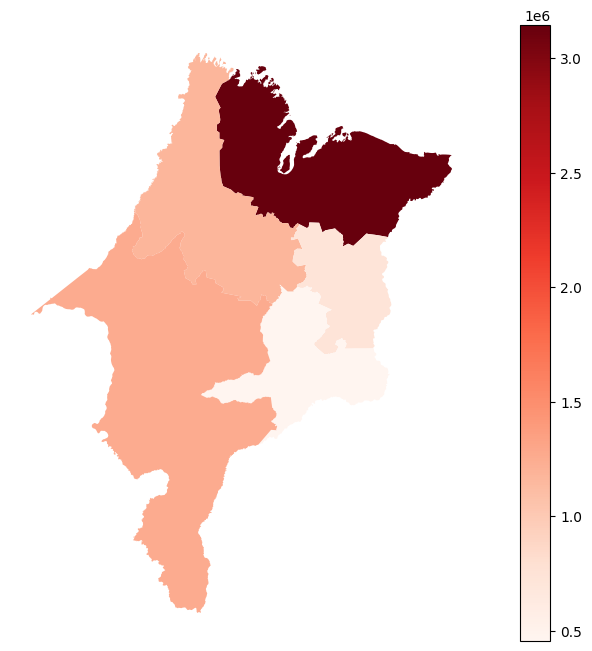

In [30]:
regioes_MA["total_hab"] = regioes_MA.apply(lambda x: hab_per_region[x['NM_RGINT']], axis=1)
# Plot the microregions
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
regioes_MA.plot(column='total_hab', ax=ax, legend=True, cmap='Reds')
plt.axis('off')
plt.show()    

In [31]:
votacao_regiao

,NM_RGINT,NM_VOTAVEL,Total_Voto,CD_RGINT,CD_UF,NM_UF,CD_REGIAO,NM_REGIAO,AREA_KM2,geometry,TOTAL_HAB_REG,VOTAVEL_QNT_VOTOS_PER_REG
0,São Luís,HILDELIS SILVA DUARTE JUNIOR,104473,2101,21,Maranhão,2,Nordeste,68393.525,"MULTIPOLYGON (((-44.92499 -3.70937, -44.92575 ...",3145399,111019
1,Santa Inês - Bacabal,MARIA DEUSDETE LIMA CUNHA RODRIGUES,77509,2102,21,Maranhão,2,Nordeste,63517.970,"MULTIPOLYGON (((-45.9244 -4.62142, -45.92563 -...",1173021,161206
2,São Luís,ALUISIO GUIMARAES MENDES FILHO,75997,2101,21,Maranhão,2,Nordeste,68393.525,"MULTIPOLYGON (((-44.92499 -3.70937, -44.92575 ...",3145399,126577
3,São Luís,JOSIMAR CUNHA RODRIGUES,73374,2101,21,Maranhão,2,Nordeste,68393.525,"MULTIPOLYGON (((-44.92499 -3.70937, -44.92575 ...",3145399,158360
4,Imperatriz,JOSIVALDO DOS SANTOS MELO,70642,2105,21,Maranhão,2,Nordeste,131547.693,"POLYGON ((-47.58923 -7.44191, -47.58944 -7.441...",1255543,79699
...,...,...,...,...,...,...,...,...,...,...,...,...
1743,Presidente Dutra,ANDREA JANE SANTOS VIANA,1,2104,21,Maranhão,2,Nordeste,38308.544,"POLYGON ((-44.41465 -7.13677, -44.41729 -7.138...",456328,57
1744,Caxias,NARLIENE CORREA DOS SANTOS,1,2103,21,Maranhão,2,Nordeste,27883.763,"POLYGON ((-44.03286 -5.89683, -44.03351 -5.895...",735054,104
1745,Santa Inês - Bacabal,GEDIEL PEREIRA ALENCAR,1,2102,21,Maranhão,2,Nordeste,63517.970,"MULTIPOLYGON (((-45.9244 -4.62142, -45.92563 -...",1173021,506
1746,Santa Inês - Bacabal,GENESIO PEREIRA DE SOUSA,1,2102,21,Maranhão,2,Nordeste,63517.970,"MULTIPOLYGON (((-45.9244 -4.62142, -45.92563 -...",1173021,267


In [32]:
# Add column with the percentage of votes from the municipality in general
votacao_regiao['RELEVANCIA_MN'] = ( votacao_regiao['Total_Voto'] * 100 ) / votacao_regiao['VOTAVEL_QNT_VOTOS_PER_REG']
votacao_regiao.head()

,NM_RGINT,NM_VOTAVEL,Total_Voto,CD_RGINT,CD_UF,NM_UF,CD_REGIAO,NM_REGIAO,AREA_KM2,geometry,TOTAL_HAB_REG,VOTAVEL_QNT_VOTOS_PER_REG,RELEVANCIA_MN
0,São Luís,HILDELIS SILVA DUARTE JUNIOR,104473,2101,21,Maranhão,2,Nordeste,68393.525,"MULTIPOLYGON (((-44.92499 -3.70937, -44.92575 ...",3145399,111019,94.103712
1,Santa Inês - Bacabal,MARIA DEUSDETE LIMA CUNHA RODRIGUES,77509,2102,21,Maranhão,2,Nordeste,63517.970,"MULTIPOLYGON (((-45.9244 -4.62142, -45.92563 -...",1173021,161206,48.080717
2,São Luís,ALUISIO GUIMARAES MENDES FILHO,75997,2101,21,Maranhão,2,Nordeste,68393.525,"MULTIPOLYGON (((-44.92499 -3.70937, -44.92575 ...",3145399,126577,60.040134
3,São Luís,JOSIMAR CUNHA RODRIGUES,73374,2101,21,Maranhão,2,Nordeste,68393.525,"MULTIPOLYGON (((-44.92499 -3.70937, -44.92575 ...",3145399,158360,46.333670
4,Imperatriz,JOSIVALDO DOS SANTOS MELO,70642,2105,21,Maranhão,2,Nordeste,131547.693,"POLYGON ((-47.58923 -7.44191, -47.58944 -7.441...",1255543,79699,88.635993


In [33]:
# Sort by PERCENTUAL_VOTOS_CANDIDATO
votacao_regiao_grouped = votacao_regiao.sort_values('RELEVANCIA_MN', ascending=False)
votacao_regiao_grouped.head()

,NM_RGINT,NM_VOTAVEL,Total_Voto,CD_RGINT,CD_UF,NM_UF,CD_REGIAO,NM_REGIAO,AREA_KM2,geometry,TOTAL_HAB_REG,VOTAVEL_QNT_VOTOS_PER_REG,RELEVANCIA_MN
1510,São Luís,INGRYD DANIELLE PIMENTEL GOMES,5,2101,21,Maranhão,2,Nordeste,68393.525,"MULTIPOLYGON (((-44.92499 -3.70937, -44.92575 ...",3145399,5,100.000000
605,São Luís,EUDIVAN CARVALHO COSTA,245,2101,21,Maranhão,2,Nordeste,68393.525,"MULTIPOLYGON (((-44.92499 -3.70937, -44.92575 ...",3145399,247,99.190283
782,São Luís,NARLIENE CORREA DOS SANTOS,103,2101,21,Maranhão,2,Nordeste,68393.525,"MULTIPOLYGON (((-44.92499 -3.70937, -44.92575 ...",3145399,104,99.038462
152,São Luís,CELIO ALEX ALVES PAIVA,5145,2101,21,Maranhão,2,Nordeste,68393.525,"MULTIPOLYGON (((-44.92499 -3.70937, -44.92575 ...",3145399,5207,98.809295
201,São Luís,DANIEL VAZ ABREU,3113,2101,21,Maranhão,2,Nordeste,68393.525,"MULTIPOLYGON (((-44.92499 -3.70937, -44.92575 ...",3145399,3154,98.700063


In [34]:
# Normalize the color scale
def plot_votes_by_candidate(candidato,norm):
    votos_candidato = votacao_regiao_grouped[votacao_regiao_grouped['NM_VOTAVEL'] == candidato]
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    votos_candidato.plot(column='RELEVANCIA_MN', ax=ax, legend=True, cmap='Reds', norm=norm)
    plt.title(f'Votos do candidato {candidato}')
    plt.axis('off')
    plt.show()

In [35]:
top10_deputados_mais_votados_list = top10_deputados_mais_votados.index.tolist()
import matplotlib.colors as mcolors
#From the top 10 most voted candidates, get the min and max values to normalize the color scale
min_value = votacao_regiao_grouped[votacao_regiao_grouped['NM_VOTAVEL'].isin(top10_deputados_mais_votados_list)]['RELEVANCIA_MN'].min()
max_value = votacao_regiao_grouped[votacao_regiao_grouped['NM_VOTAVEL'].isin(top10_deputados_mais_votados_list)]['RELEVANCIA_MN'].max()
norm = mcolors.Normalize(vmin=min_value, vmax=max_value)


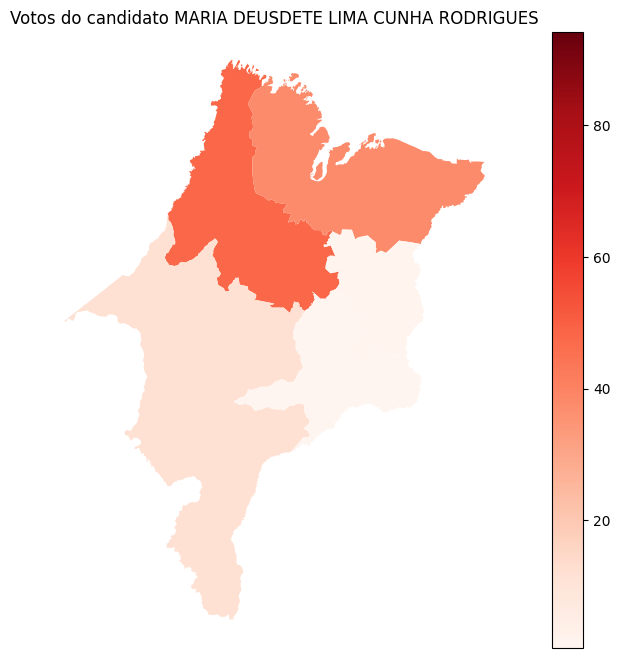

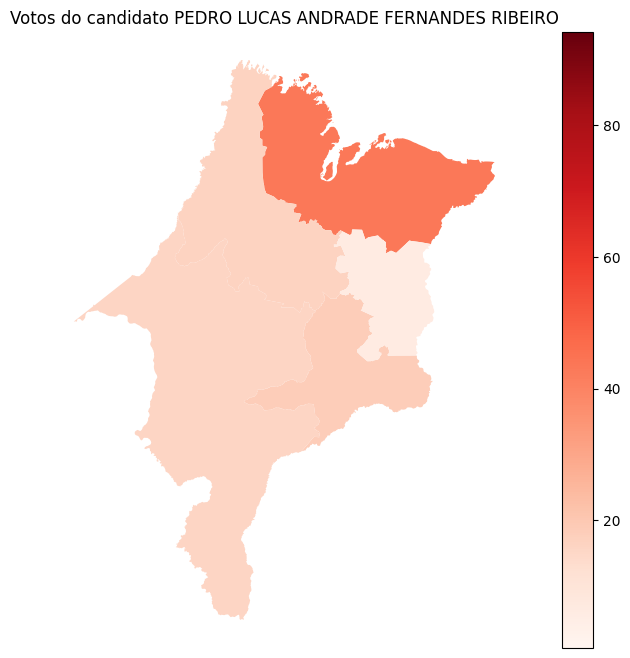

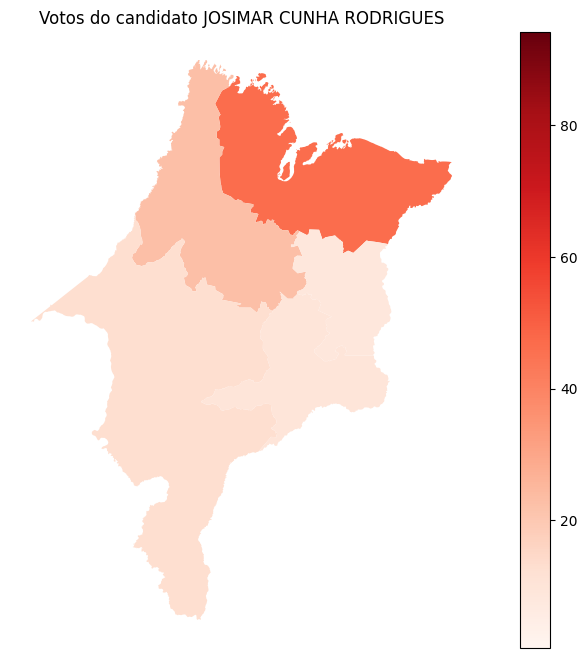

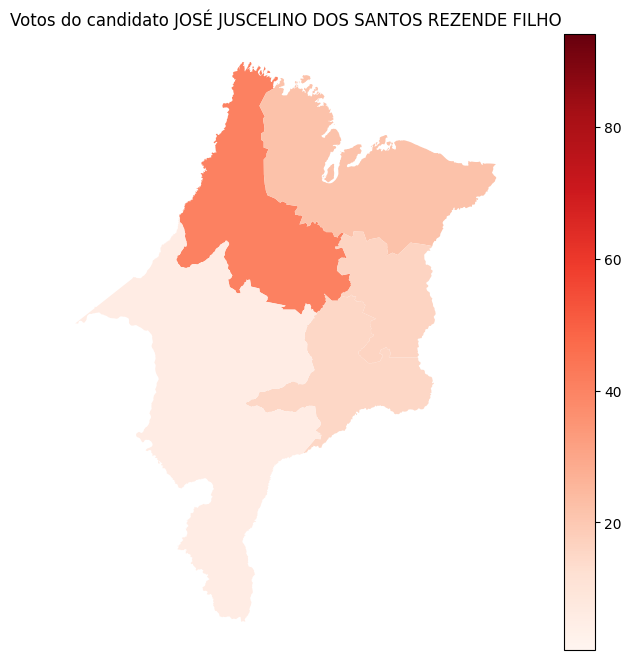

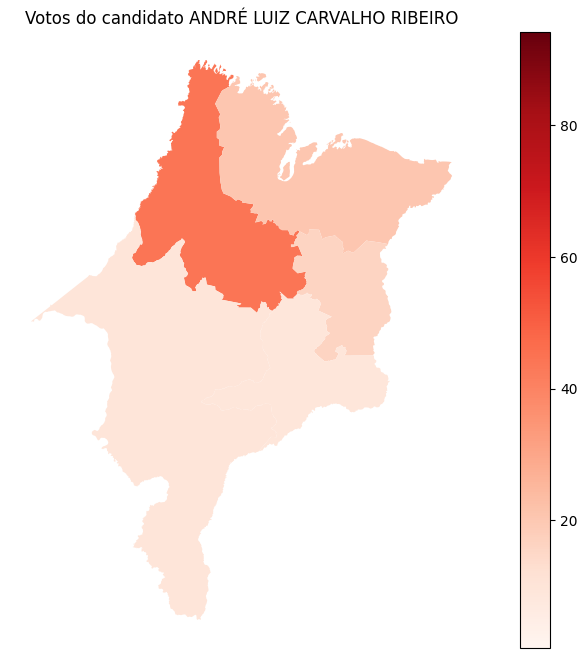

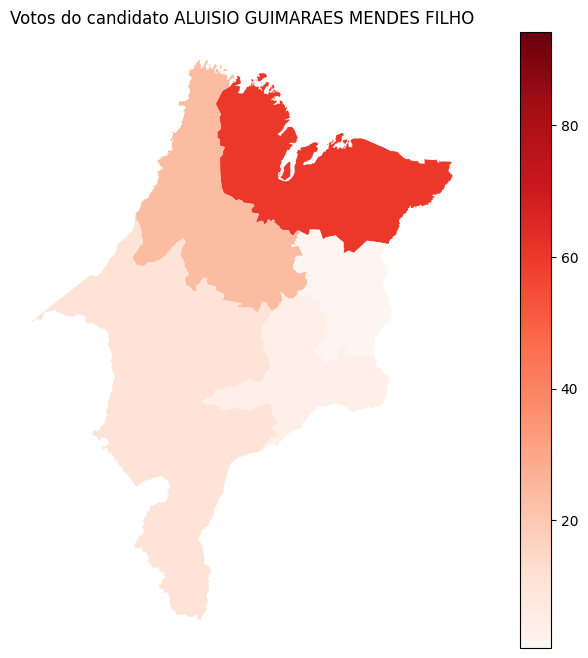

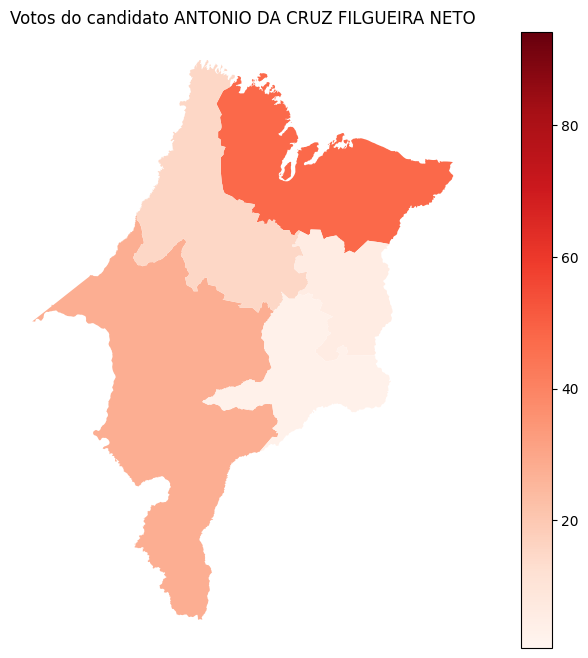

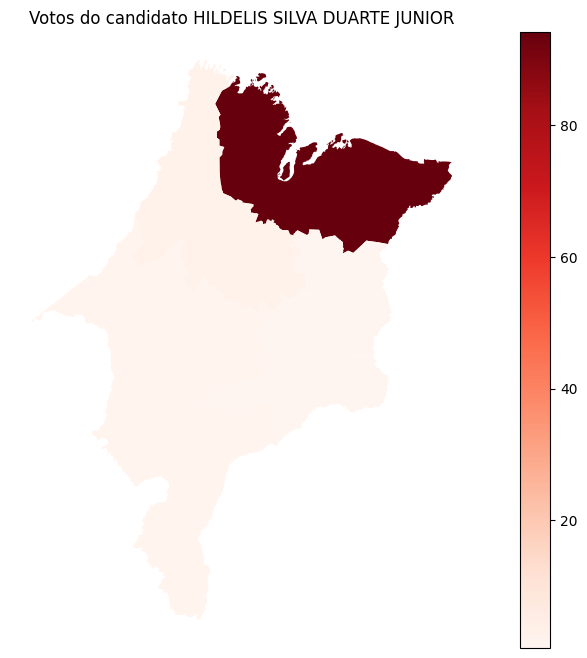

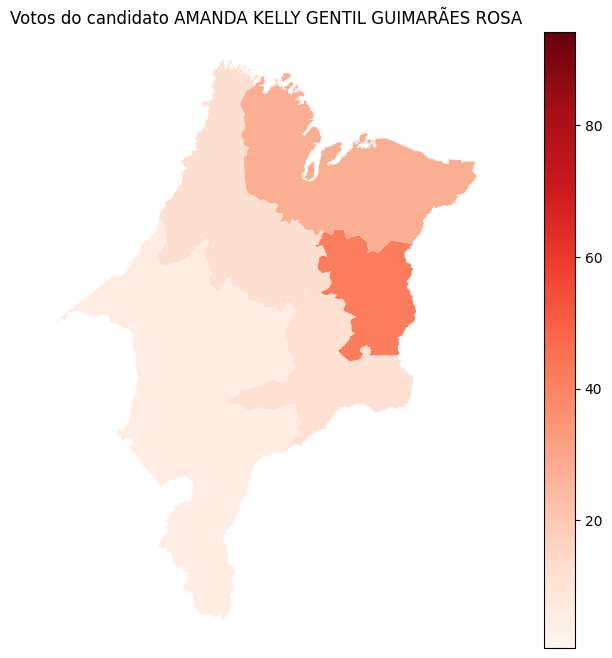

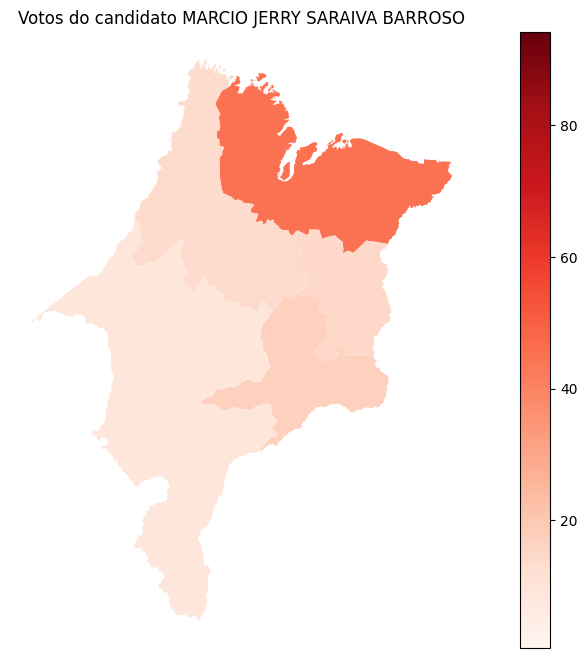

In [36]:
for deputado in top10_deputados_mais_votados_list:
    plot_votes_by_candidate(deputado,norm)

## Correlação com dados socioeconômicos

> Correlação entre Gênero e Taxa de Participação

**Calcular a taxa de participação por gênero** (ex.: proporção de eleitores masculinos e femininos que compareceram para votar em cada município)

**Visualizar em um mapa geográfico**

Por que é interessante: Ajuda a identificar possíveis diferenças de engajamento entre homens e mulheres em diferentes regiões

In [37]:
perfil_eleitor.columns


Index(['CD_MUNICIPIO', 'NM_MUNICIPIO', 'DS_GENERO', 'DS_FAIXA_ETARIA',
       'DS_GRAU_ESCOLARIDADE', 'DS_RACA_COR', 'DS_IDENTIDADE_GENERO',
       'DS_QUILOMBOLA', 'DS_INTERPRETE_LIBRAS', 'QT_ELEITORES_PERFIL'],
      dtype='object')

In [38]:
perfil_eleitor.head()

,CD_MUNICIPIO,NM_MUNICIPIO,DS_GENERO,DS_FAIXA_ETARIA,DS_GRAU_ESCOLARIDADE,DS_RACA_COR,DS_IDENTIDADE_GENERO,DS_QUILOMBOLA,DS_INTERPRETE_LIBRAS,QT_ELEITORES_PERFIL
0,2100154,ÁGUA DOCE DO MARANHÃO,FEMININO,100 anos ou mais,ANALFABETO,NÃO INFORMADO,NÃO INFORMADO,NÃO INFORMADO,NÃO INFORMADO,2
1,2100154,ÁGUA DOCE DO MARANHÃO,FEMININO,100 anos ou mais,LÊ E ESCREVE,NÃO INFORMADO,NÃO INFORMADO,NÃO INFORMADO,NÃO INFORMADO,1
2,2100154,ÁGUA DOCE DO MARANHÃO,FEMININO,16 anos,ENSINO FUNDAMENTAL COMPLETO,Branca,Cisgênero,NÃO,NÃO,3
3,2100154,ÁGUA DOCE DO MARANHÃO,FEMININO,16 anos,ENSINO FUNDAMENTAL COMPLETO,Parda,Cisgênero,NÃO,NÃO,3
4,2100154,ÁGUA DOCE DO MARANHÃO,FEMININO,16 anos,ENSINO FUNDAMENTAL COMPLETO,Parda,Prefere não informar,NÃO,NÃO,1


In [39]:
feminino_eleitores = perfil_eleitor[perfil_eleitor['DS_GENERO'] == 'FEMININO'].groupby(['NM_MUNICIPIO','CD_MUNICIPIO'])['QT_ELEITORES_PERFIL'].sum()
eleitoras_por_municipio = pd.DataFrame(perfil_eleitor[perfil_eleitor['DS_GENERO'] == 'FEMININO'].reset_index().groupby(['NM_MUNICIPIO','CD_MUNICIPIO'])['QT_ELEITORES_PERFIL'].sum(), columns=['NM_MUNICIPIO','CD_MUNICIPIO', 'QT_ELEITORES_PERFIL'])
eleitoras_por_municipio = pd.DataFrame({
    'NM_MUNICIPIO': feminino_eleitores.index.get_level_values(0),
    'CD_MUNICIPIO': feminino_eleitores.index.get_level_values(1),
    'QT_ELEITORES_PERFIL': feminino_eleitores.values
})
eleitoras_por_municipio.rename(columns={'QT_ELEITORES_PERFIL': 'QT_ELEITORAS_PERFIL'}, inplace=True)

masculino_eleitores = perfil_eleitor[perfil_eleitor['DS_GENERO'] == 'MASCULINO'].groupby(['NM_MUNICIPIO','CD_MUNICIPIO'])['QT_ELEITORES_PERFIL'].sum()
eleitores_por_municipio = pd.DataFrame(perfil_eleitor[perfil_eleitor['DS_GENERO'] == 'MASCULINO'].reset_index().groupby(['NM_MUNICIPIO','CD_MUNICIPIO'])['QT_ELEITORES_PERFIL'].sum(), columns=['NM_MUNICIPIO','CD_MUNICIPIO', 'QT_ELEITORES_PERFIL'])
eleitores_por_municipio = pd.DataFrame({
    'NM_MUNICIPIO': masculino_eleitores.index.get_level_values(0),
    'CD_MUNICIPIO': masculino_eleitores.index.get_level_values(1),
    'QT_ELEITORES_PERFIL': masculino_eleitores.values
})

# Merge eleitores_por_municipio and eleitoras_por_municipio DataFrames
eleitores_por_municipio = eleitores_por_municipio.merge(eleitoras_por_municipio, on=['NM_MUNICIPIO', 'CD_MUNICIPIO'])

In [50]:
# Configurar o shapefile
maranhao_shapefile = "MA_Municipios_2023/MA_Municipios_2023.shp"
gdf = gpd.read_file(maranhao_shapefile)


In [51]:

# Padronizar os nomes dos municípios
gdf['NM_MUN'] = gdf['NM_MUN'].str.upper()
gdf = gdf.rename(columns={'NM_MUN': 'NM_MUNICIPIO'})

In [52]:

# Merge com os dados de eleitores
gdf = gdf.merge(eleitores_por_municipio, on='NM_MUNICIPIO', how='left')
gdf = gpd.GeoDataFrame(gdf)


In [54]:
gdf = gdf.rename(columns={'QT_ELEITORES_PERFIL': 'Masculino', 'QT_ELEITORAS_PERFIL': 'Feminino'})

/tmp/ipykernel_2573/246275761.py:11: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  gdf.plot(column='Gênero Predominante',


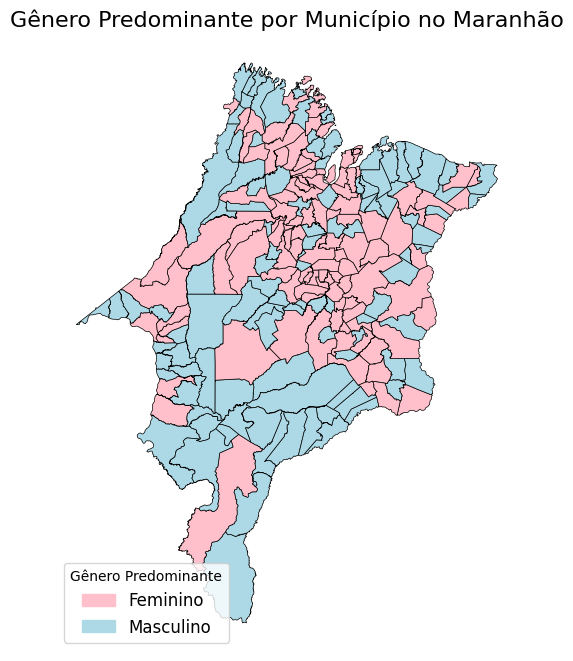

In [55]:
gdf[['Masculino', 'Feminino']] = gdf[['Masculino', 'Feminino']].fillna(0)

# Determinar o gênero predominante
gdf['Gênero Predominante'] = gdf.apply(lambda row: 'Feminino' if row['Feminino'] > row['Masculino'] else 'Masculino', axis=1)

# Configuração de cores para os gêneros
cor_mapa = {'Feminino': 'pink', 'Masculino': 'lightblue'}

# Plotar o mapa com bordas pretas
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
gdf.plot(column='Gênero Predominante',
         color=gdf['Gênero Predominante'].map(cor_mapa),
         linewidth=0.5,
         edgecolor='black',  # Configurar as bordas pretas
         ax=ax)

# Configurações do título
ax.set_title('Gênero Predominante por Município no Maranhão', fontsize=16)
ax.axis('off')

# Criar legenda personalizada
handles = [Patch(color=cor, label=genero) for genero, cor in cor_mapa.items()]
ax.legend(handles=handles, loc='lower left', fontsize=12, title="Gênero Predominante")

# Exibir o mapa
plt.show()

In [56]:
# Filtrar apenas os candidatos a deputado estadual
deputados_estaduais = votacao_mun.copy()

# Remover linhas onde o nome contém "Partido", "Nulo", "Branco", entre outros
filtros = ["Partido", "Nulo", "Branco", "Movimento", "União", "Progressistas"]
for filtro in filtros:
    deputados_estaduais = deputados_estaduais[~deputados_estaduais['NM_VOTAVEL'].str.contains(filtro, case=False, na=False)]

# Agrupar por candidato e município, somando os votos
votos_por_deputado = deputados_estaduais.groupby(['NM_MUN', 'NM_VOTAVEL'])['Total_Voto'].sum().reset_index()

# Ordenar os deputados por número de votos em ordem decrescente
votos_por_deputado = votos_por_deputado.sort_values(by='Total_Voto', ascending=False)

votos_por_deputado


,NM_MUN,NM_VOTAVEL,Total_Voto
26607,SÃO LUÍS,HILDELIS SILVA DUARTE JUNIOR,76264
26757,SÃO LUÍS,ROSEANA SARNEY MURAD,39351
28214,TIMON,HENRIQUE CESAR FERREIRA DE MELO LIMA JUNIOR,34214
12591,IMPERATRIZ,JOSIVALDO DOS SANTOS MELO,28969
28256,TIMON,JOSÉ JUSCELINO DOS SANTOS REZENDE FILHO,25792
...,...,...,...
19558,PERITORÓ,RAIMUNDO MONTEIRO DOS SANTOS,1
19559,PERITORÓ,RAISSA MARTINS MENDONCA,1
19564,PERITORÓ,ROBERTO SILVA MAUES,1
19565,PERITORÓ,RODRIGO SILVA DE MEDEIROS PASSOS,1


In [57]:
# Obter uma lista única de todos os candidatos no dataset
todos_candidatos =  votacao_mun['NM_VOTAVEL'].drop_duplicates().sort_values()

candidatas_nomes = [
    "ABIGAIL CUNHA DE ALMEIDA SOUSA",
    "ADENÓLIA PIRES SILVA RIBEIRO",
    "ADRIANA NUNES MENDES",
    "ALAYNA DE ARAUJO ROCHA SOUZA",
    "ALBERLUCE DE JESUS FURTADO DURANS",
    "ALBERTINA SILVA ROCHA",
    "ALECIANE DO NASCIMENTO LOPES",
    "ALEXSANDRA MELO ESTRELA",
    "ALEXSANDRA VIANA PEREIRA",
    "ALINE MARIA DOS SANTOS PEREIRA",
    "AMANDA KELLY GENTIL GUIMARÃES ROSA",
    "ANA BEATRIZ DOS SANTOS VIEIRA",
    "ANA CATHARINE MELO SEKEFF",
    "ANA CLERES SANTOS FERREIRA",
    "ANA CLÁUDIA SANTOS",
    "ANA DE NAZARÉ PEREIRA SILVA MACEDO MENDONÇA",
    "ANA MARIA ALMEIDA COSTA",
    "ANA PAULA SILVA ROXO",
    "ANDREA JANE SANTOS VIANA",
    "ANDREIA LOPES MARTINS REZENDE",
    "ANGELA COSTA DE MELO",
    "ANGELA MARIA LIMA DOS SANTOS",
    "ANN MICHELLE MARQUES BOTELHO",
    "ARACELE DE JESUS FONSECA SILVA",
    "ARILSA MALAQUIAS BRANDÃO",
    "ARLETE SANTOS MOREIRA LIMA",
    "ARTENISA CAETANO DA SILVA",
    "BRENDA CARVALHO PEREIRA",
    "BRUNA EVERTON DE MORAIS RÊGO SARAIVA LEAO",
    "BRUNA GRACIELE BASTOS",
    "BRUNA THALYTA GUTERRES GUIMARÃES",
    "BRUNNA DE SOUZA AMORIM MARCIEL",
    "BYANCA REGINA BARBOSA DOS PASSOS",
    "CAROLINA RAISSA DE MENEZES ARAÚJO COSTA",
    "CAROLINE CARVALHO NOLETO",
    "CAROLINE FERNANDA SOUSA BOUERES DOS SANTOS",
    "CLAUDIA FABIANA VIEIRA SILVA",
    "CLAUDIA GUILHERMINA BRITO LIRA",
    "CLAUDIA MELO LIMA",
    "CLAUDIONICE ALVES DURANS",
    "CONCEICAO DE MARIA BEZERRA ALMEIDA",
    "CONCEIÇÃO DE MARIA AMORIM PIMENTA",
    "CONCEIÇÃO DE MARIA CASTRO ALBUQUERQUE",
    "CONCEIÇÃO SILVA DE SOUSA",
    "CRICIELLE AGUIAR MUNIZ",
    "CRISTIANE VASCONCELOS BACELAR",
    "CRISTYANE SOUSA SILVA",
    "DANIELE DA CRUZ CAMBRAIA",
    "DANIELLA JADÃO MENESES CUNHA",
    "DARCILENE DA SILVA SOUZA",
    "DEISE SILVA PÁDUA",
    "DENISE CARVALHO GOMES",
    "DINA DIAS DA SILVA",
    "DORALICE LOPES SANTANA",
    "DYANE DE MORAIS",
    "EDILENE DA SILVA FREITAS",
    "EDNA PIRES MONTEIRO MARTINS",
    "EDNA SANTOS SILVA",
    "ELAINE CRISTINA MARQUES CORTEZ",
    "ELANY ROSA DE ASSIS",
    "ELENILDES DA CONCEIÇÃO RIBEIRO BRAGA",
    "ELIJANE CÉLIA CUTRIM BARROS",
    "ELINE CARLA PINHEIRO CARDOSO",
    "ELIZABETE DE MORAIS AFONSO",
    "ELIZANIA DO ESPIRITO SANTO FERNANDES",
    "ELMARENE SOUSA MAIA",
    "EMILCE MARIA CAMPOS",
    "EMÍLIA ROSA FIGUEIREDO BARROS",
    "ERICA CRISTINA CUNHA BARBOSA",
    "ESMERALDA LACERDA ARAUJO FRANÇA",
    "EVELLYN FERREIRA GERALDO",
    "FABIANA CRISTINA SILVA CUTRIM",
    "FABIANA VILAR RODRIGUES",
    "FERNANDA KATHERINE AZEVEDO GUERREIRO MOTA",
    "FERNANDA MARIA PARENTE ALVES",
    "FRANCILENE MARTINS MINEIRO",
    "FRANCINEIDE DA SILVA CORREA",
    "FRANCISCA AMÁLIA MACHADO FERRAZ",
    "FRANCISCA MARCIA DA CONCEIÇÃO",
    "FRANCISCA WELANE GOMES LOPES",
    "GEISA LOURDES MIRANDA DOS SANTOS",
    "GILVANIA FERREIRA DA SILVA",
    "HELENA MARIA DUAILIBE FERREIRA",
    "IRACEMA CRISTINA VALE LIMA",
    "JANAINA LIMA ARAÚJO RAMOS",
    "JHENYFER PAULA DO NASCIMENTO",
    "JOANA BENTO DE SOUSA LIMA",
    "JOANA NUNES PINHEIRO",
    "JOANICE DE OLIVEIRA RIOS",
    "JOCIANNE FERREIRA GOMES MATOS",
    "JOELMA VIANA CANTANHEDE",
    "KARINA LEDA BORJAS",
    "KARLA BATISTA CABRAL SOUZA",
    "KARLYANE FERREIRA CÃMARA",
    "KATIUSCIA SILVA FERREIRA",
    "LUANA MARIA DA SILVA COSTA",
    "LUANA THAIS SANTOS CARVALHO",
    "LUCIANA COSTA CORREA",
    "LUCIANA SILVA DE ABREU",
    "MAYANE MARTINS PEREIRA",
    "MILENA DE OLIVEIRA SANTOS CALAFELL ARAUJO",
    "NATHALIA GRAZIELLE DOS SANTOS SILVA",
    "RITA DE CASSIA CORDEIRO AMARAL",
    "ROSA CARVALHO MESQUITA",
    "ROSANA MARIA SOUSA DE LIMA",
    "ROSEANA SARNEY MURAD",
    "ROSÂNGELA DE JESUS VIEIRA AZEVEDO",
    "SANDRA MARIA ABREU",
    "SANDRA MARIA ANDRADE DAVID",
    "SANDRA MARIA OLIVEIRA SILVA",
    "THAIZA DE AGUIAR HORTEGAL",
    "VANESSA CAMPOS BENÍCIO MURAD",
    "VANESSA RODRIGUES LIMA",
    "VIVIANNE MARTINS COELHO E SILVA",
    "ZILDA MARTINS FONSECA SIQUEIRA",
    "ZILMARA DE JESUS LIMA",
]

# Criar a coluna 'GENERO' com base nos nomes das candidatas femininas
votos_por_deputado['GENERO'] = votos_por_deputado['NM_VOTAVEL'].apply(lambda nome: 'Feminino' if nome in candidatas_nomes else 'Masculino')

# Exibir o DataFrame atualizado
votos_por_deputado



,NM_MUN,NM_VOTAVEL,Total_Voto,GENERO
26607,SÃO LUÍS,HILDELIS SILVA DUARTE JUNIOR,76264,Masculino
26757,SÃO LUÍS,ROSEANA SARNEY MURAD,39351,Feminino
28214,TIMON,HENRIQUE CESAR FERREIRA DE MELO LIMA JUNIOR,34214,Masculino
12591,IMPERATRIZ,JOSIVALDO DOS SANTOS MELO,28969,Masculino
28256,TIMON,JOSÉ JUSCELINO DOS SANTOS REZENDE FILHO,25792,Masculino
...,...,...,...,...
19558,PERITORÓ,RAIMUNDO MONTEIRO DOS SANTOS,1,Masculino
19559,PERITORÓ,RAISSA MARTINS MENDONCA,1,Masculino
19564,PERITORÓ,ROBERTO SILVA MAUES,1,Masculino
19565,PERITORÓ,RODRIGO SILVA DE MEDEIROS PASSOS,1,Masculino


In [58]:
# Agrupar por município e gênero, somando os votos
votos_por_genero_municipio = votos_por_deputado.groupby(['NM_MUN', 'GENERO'])['Total_Voto'].sum().reset_index()

# Transformar os dados para ter colunas separadas por gênero
votos_por_genero_municipio_pivot = votos_por_genero_municipio.pivot(index='NM_MUN', columns='GENERO', values='Total_Voto').fillna(0)

# Renomear as colunas para algo mais legível
votos_por_genero_municipio_pivot = votos_por_genero_municipio_pivot.rename(columns={
    'Feminino': 'Votos em candidatas',
    'Masculino': 'Votos em candidatos'
})

# Resetar o índice para exibição
votos_por_genero_municipio_pivot = votos_por_genero_municipio_pivot.reset_index()

# Exibir o DataFrame resultante
votos_por_genero_municipio_pivot



GENERO,NM_MUN,Votos em candidatas,Votos em candidatos
0,AFONSO CUNHA,1169,4079
1,ALCÂNTARA,1352,23002
2,ALDEIAS ALTAS,2240,10161
3,ALTAMIRA DO MARANHÃO,46,3699
4,ALTO ALEGRE DO MARANHÃO,539,12230
...,...,...,...
212,VILA NOVA DOS MARTÍRIOS,91,5872
213,VITORINO FREIRE,188,16137
214,VITÓRIA DO MEARIM,637,15999
215,ZÉ DOCA,1331,21439


In [59]:
# Adicionar uma coluna apenas para a proporção de votos femininos
votos_por_genero_municipio_pivot['Proporção Votos Femininos'] = votos_por_genero_municipio_pivot['Votos em candidatas'] / (votos_por_genero_municipio_pivot['Votos em candidatas'] + votos_por_genero_municipio_pivot['Votos em candidatos'])

# Exibir apenas as colunas que deseja visualizar
colunas_desejadas = ['NM_MUN', 'Votos em candidatas', 'Votos em candidatos', 'Proporção Votos Femininos']
votos_por_genero_municipio_pivot = votos_por_genero_municipio_pivot[colunas_desejadas]

# Ordenar pela maior proporção de votos em candidatas e selecionar os 15 primeiros municípios
top_15_municipios_femininos = votos_por_genero_municipio_pivot.sort_values(
    by='Proporção Votos Femininos', ascending=False
).head(15)

# Exibir o resultado
top_15_municipios_femininos



GENERO,NM_MUN,Votos em candidatas,Votos em candidatos,Proporção Votos Femininos
49,CAXIAS,27891,50501,0.355789
92,JATOBÁ,1424,3489,0.289843
65,DUQUE BACELAR,1826,5132,0.262432
179,SÃO DOMINGOS DO MARANHÃO,4868,14799,0.247521
0,AFONSO CUNHA,1169,4079,0.222752
188,SÃO JOÃO DO SOTER,2212,7752,0.221999
144,PIRAPEMAS,1760,6790,0.205848
82,GRAÇA ARANHA,929,3690,0.201126
162,SANTA LUZIA,6188,25206,0.197108
69,FERNANDO FALCÃO,1276,5716,0.182494


In [60]:
print(gdf.columns)
print(votos_por_genero_municipio_pivot.columns)

Index(['CD_MUN', 'NM_MUNICIPIO', 'CD_RGI', 'NM_RGI', 'CD_RGINT', 'NM_RGINT',
       'CD_UF', 'NM_UF', 'CD_REGIAO', 'NM_REGIAO', 'CD_CONCURB', 'NM_CONCURB',
       'AREA_KM2', 'geometry', 'CD_MUNICIPIO', 'Masculino', 'Feminino',
       'Gênero Predominante'],
      dtype='object')
Index(['NM_MUN', 'Votos em candidatas', 'Votos em candidatos',
       'Proporção Votos Femininos'],
      dtype='object', name='GENERO')


/tmp/ipykernel_2573/2447183587.py:3: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  gdf.plot(column='Gênero Predominante',


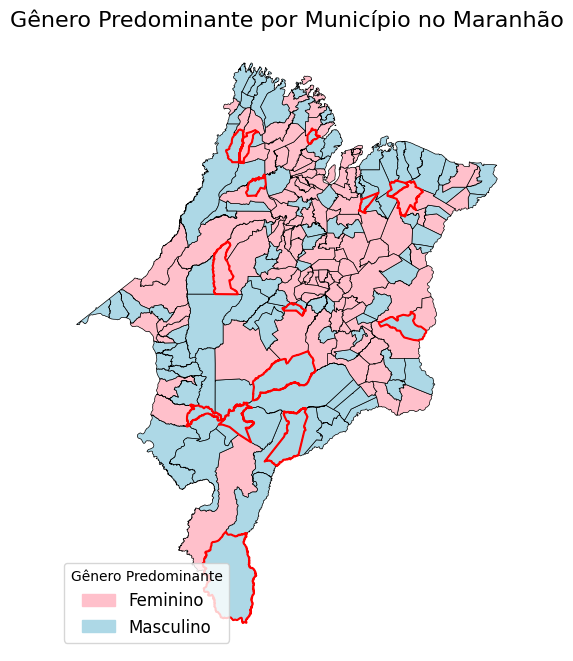

In [61]:
# Plotar o mapa com bordas pretas
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
gdf.plot(column='Gênero Predominante',
         color=gdf['Gênero Predominante'].map(cor_mapa),
         linewidth=0.5,
         edgecolor='black',  # Configurar as bordas pretas
         ax=ax)

# Configurações do título
ax.set_title('Gênero Predominante por Município no Maranhão', fontsize=16)
ax.axis('off')

# Criar legenda personalizada
handles = [Patch(color=cor, label=genero) for genero, cor in cor_mapa.items()]
ax.legend(handles=handles, loc='lower left', fontsize=12, title="Gênero Predominante")

municipios_destaque = [
    "FERNANDO FALCÃO", "URBANO SANTOS", "SÃO PEDRO DOS CRENTES", "BURITICUPU", "BELÁGUA",
    "FORTALEZA DOS NOGUEIRAS", "MARANHÃOZINHO", "CENTRO DO GUILHERME", "ARAGUANÃ",
    "MATÕES", "LORETO", "ALTO PARNAÍBA", "SÃO RAIMUNDO DO DOCA BEZERRA",
    "CENTRAL DO MARANHÃO", "PRESIDENTE VARGAS"
]

# Destaque para os municípios da lista
gdf[gdf['NM_MUNICIPIO'].isin(municipios_destaque)].plot(
    ax=ax,
    color='none',  # Sem preenchimento
    edgecolor='red',  # Bordas em vermelho
    linewidth=1.5  # Bordas mais grossas
)

# Exibir o mapa
plt.show()

A partir do mapa gerado e da análise dos municípios com maior proporção de votos em candidatas mulheres, observa-se que não há uma relação clara entre a predominância de eleitoras em um município e o voto em candidatas do gênero feminino. Embora esperássemos que municípios com mais eleitoras tendessem a apoiar mais candidatas mulheres, os dados indicam que outros fatores podem ser mais determinantes para explicar os resultados eleitorais.

Pontos principais da análise:


Distribuição geográfica: Os municípios destacados no mapa, com maior proporção de votos em candidatas, estão espalhados em várias regiões do estado. Essa dispersão não sugere um padrão regional ou uma concentração significativa em áreas com predominância de eleitoras.

Variação na dinâmica eleitoral local: O voto em candidatas pode estar mais relacionado a fatores locais, como o perfil da candidata, sua atuação na comunidade, ou mesmo seu partido político, do que ao gênero dos eleitores.

Influência cultural e social: O comportamento eleitoral no Maranhão, como em outros estados brasileiros, pode ser influenciado por aspectos culturais, religiosos ou sociais que muitas vezes transcendem a questão do gênero. Por exemplo, eleitoras podem optar por votar em candidatos homens devido à tradição política ou à identificação com pautas defendidas por esses candidatos.

Predominância de candidaturas masculinas: Considerando que o número de candidatos homens geralmente é muito maior que o de mulheres, a competição eleitoral tende a favorecer os homens em diversas localidades, independentemente do número de eleitoras.

Exceções no padrão: Embora não haja um padrão claro, alguns municípios destacaram-se pela alta proporção de votos em candidatas, como Fernando Falcão e Urbano Santos. Esses casos podem ser explorados mais a fundo para entender os motivos que levaram a esse comportamento.

## Autocorrelação espacial por partido

In [62]:
# Remove as linhas duplicadas, mantendo apenas a primeira ocorrência
deputados_federais = votacao_mun[(votacao_mun.duplicated(subset=['CD_MUN', 'NR_VOTAVEL'], keep='first') == False)]

# Agrupa por candidato (NM_VOTAVEL), somando votos
votos_por_candidato_federal = deputados_federais.groupby(['NM_VOTAVEL', 'NR_VOTAVEL'])['Total_Voto'].sum().sort_values(ascending=False)

# Encontra os 5 candidatos mais votados para deputado federal
top_5_deputados_federais = votos_por_candidato_federal.head(5)

print(top_5_deputados_federais)

NM_VOTAVEL                               NR_VOTAVEL
MARIA DEUSDETE LIMA CUNHA RODRIGUES      2233          161206
PEDRO LUCAS ANDRADE FERNANDES RIBEIRO    4444          159786
JOSIMAR CUNHA RODRIGUES                  2222          158360
JOSÉ JUSCELINO DOS SANTOS REZENDE FILHO  4410          142419
ANDRÉ LUIZ CARVALHO RIBEIRO              1111          135078
Name: Total_Voto, dtype: int64


In [63]:
def count_votes_by_party(df):
    """
    Conta os votos totais recebidos por cada partido no DataFrame 'votacao_mun'.
    Usa os dois primeiros dígitos de 'NR_VOTAVEL' como dígito do partido.
    Ordena os partidos por total de votos recebidos em ordem decrescente.

    Args:
        df: DataFrame contendo os dados de votação com as colunas 'NR_VOTAVEL' (número do candidato) e 'Total_Voto' (total de votos).

    Retorna:
        DataFrame com a contagem de votos agrupados por dígito do partido, ordenado pelo total de votos.
    """

    df['Party_Digit'] = df['NR_VOTAVEL'].astype(str).str[:2].astype(int)

    vote_counts = df.groupby(['Party_Digit'])['Total_Voto'].sum().reset_index()

    vote_counts = vote_counts.sort_values(by=['Total_Voto'], ascending=False)

    return vote_counts

votes_by_party = count_votes_by_party(votacao_mun)

print(votes_by_party)

    Party_Digit  Total_Voto
11           22      737877
21           44      440593
5            15      348178
1            11      343647
19           40      315117
8            19      281857
9            20      265739
3            13      258826
24           51      258701
25           55      256392
2            12      222431
26           65      222270
0            10      221378
30           95      158828
31           96       87793
12           23       81321
18           36        9822
29           90        9406
27           70        9158
16           30        7234
23           50        6638
4            14        6280
20           43        5158
22           45        4034
6            16        3376
13           27        2697
28           77        2529
14           28        2520
17           35        2020
7            18        1843
10           21        1834
15           29         263


In [64]:
def most_voted_party_by_municipality(df):
    """
    Identifica o partido político mais votado em cada município com base no DataFrame 'votacao_mun'.
    Utiliza os dois primeiros dígitos de 'NR_VOTAVEL' para identificar o partido.
    Retorna o nome do município e o número do partido político mais votado.

    Args:
        df: DataFrame contendo os dados de votação com as colunas 'NM_MUN' (nome do município), 'NR_VOTAVEL' (número do candidato), 'NM_VOTAVEL' (nome do candidato) e 'Total_Voto' (total de votos).

    Retorna:
        DataFrame com o nome do município e o nome do partido político mais votado.
    """

    df['Party_Digit'] = df['NR_VOTAVEL'].astype(str).str[:2].astype(int)

    votes_by_municipality_party = df.groupby(['NM_MUN', 'Party_Digit', 'NM_VOTAVEL'])['Total_Voto'].sum().reset_index()

    most_voted_party_index = votes_by_municipality_party.groupby('NM_MUN')['Total_Voto'].idxmax()
    most_voted_party = votes_by_municipality_party.loc[most_voted_party_index]

    most_voted_party = most_voted_party.rename(columns={'NM_MUN': 'NM_MUNICIPIO'})

    return most_voted_party[['NM_MUNICIPIO', 'Party_Digit']] # Return Party_Digit instead of NR_VOTAVEL

most_voted = most_voted_party_by_municipality(votacao_mun)
print(most_voted)

                  NM_MUNICIPIO  Party_Digit
56                AFONSO CUNHA           22
246                  ALCÂNTARA           44
378              ALDEIAS ALTAS           22
522       ALTAMIRA DO MARANHÃO           44
686    ALTO ALEGRE DO MARANHÃO           44
...                        ...          ...
34104  VILA NOVA DOS MARTÍRIOS           22
34301          VITORINO FREIRE           44
34450        VITÓRIA DO MEARIM           22
34667                  ZÉ DOCA           22
34822    ÁGUA DOCE DO MARANHÃO           15

[217 rows x 2 columns]


In [65]:
print(gdf.columns)
most_voted_by_municipality = most_voted_party_by_municipality(votacao_mun)
print(most_voted_by_municipality.columns)

Index(['CD_MUN', 'NM_MUNICIPIO', 'CD_RGI', 'NM_RGI', 'CD_RGINT', 'NM_RGINT',
       'CD_UF', 'NM_UF', 'CD_REGIAO', 'NM_REGIAO', 'CD_CONCURB', 'NM_CONCURB',
       'AREA_KM2', 'geometry', 'CD_MUNICIPIO', 'Masculino', 'Feminino',
       'Gênero Predominante'],
      dtype='object')
Index(['NM_MUNICIPIO', 'Party_Digit'], dtype='object')


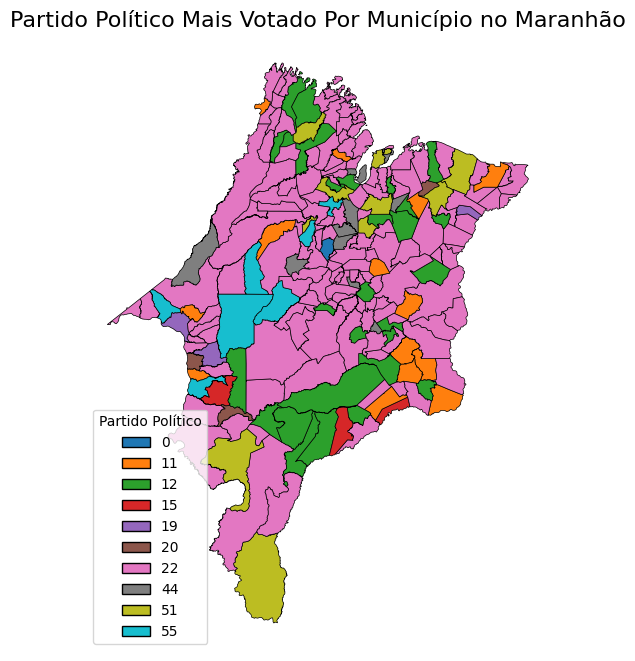

In [66]:
def plot_most_voted_party_map(df, shapefile_path):
    """
    Plota um mapa mostrando o partido político mais votado em cada município usando o DataFrame 'votacao_mun', considerando apenas os dois primeiros dígitos de 'NR_VOTAVEL'.

    Args:
        df: DataFrame contendo os dados de votação (votacao_mun).
        shapefile_path: Caminho para o shapefile contendo os limites dos municípios.
    """

    df['NR_PARTIDO'] = df['NR_VOTAVEL'].astype(str).str[:2].astype(int)

    # Obtem o partido mais votado por município usando 'NR_PARTIDO'
    most_voted_by_municipality = df.groupby('NM_MUN')['NR_PARTIDO'].agg(lambda x: x.value_counts().idxmax()).reset_index()

    # Prepara o shapefile
    gdf = gpd.read_file(shapefile_path)
    gdf['NM_MUN'] = gdf['NM_MUN'].str.upper().str.strip()

    # Garante que os nomes das colunas correspondam
    most_voted_by_municipality['NM_MUN'] = most_voted_by_municipality['NM_MUN'].str.upper().str.strip()

    # Realiza o merge do shapefile com os dados eleitorais
    gdf = gdf.merge(most_voted_by_municipality, on='NM_MUN', how='left')

    # Substitui valores ausentes em 'NR_PARTIDO' por 0
    gdf['NR_PARTIDO'] = gdf['NR_PARTIDO'].fillna(0)

    # Pegar os partidos únicos e ordená-los
    unique_parties = sorted(gdf['NR_PARTIDO'].unique())

    # Gera o colormap e o dicionário para mapear partidos às cores
    cmap = plt.colormaps['tab10']
    party_colors = {party: cmap(i / len(unique_parties)) for i, party in enumerate(unique_parties)}

    # Adiciona a coluna 'Party_Color' ao GeoDataFrame com base no mapeamento
    gdf['Party_Color'] = gdf['NR_PARTIDO'].map(party_colors)

    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    gdf.plot(color=gdf['Party_Color'], linewidth=0.5, edgecolor='black', ax=ax)

    ax.set_title('Partido Político Mais Votado Por Município no Maranhão', fontsize=16)
    ax.axis('off')

    legend_elements = [Patch(facecolor=party_colors[party], edgecolor='black', label=int(party))
                       for party in unique_parties]
    ax.legend(handles=legend_elements, loc='lower left', title="Partido Político")

    plt.show()

plot_most_voted_party_map(votacao_mun, maranhao_shapefile)

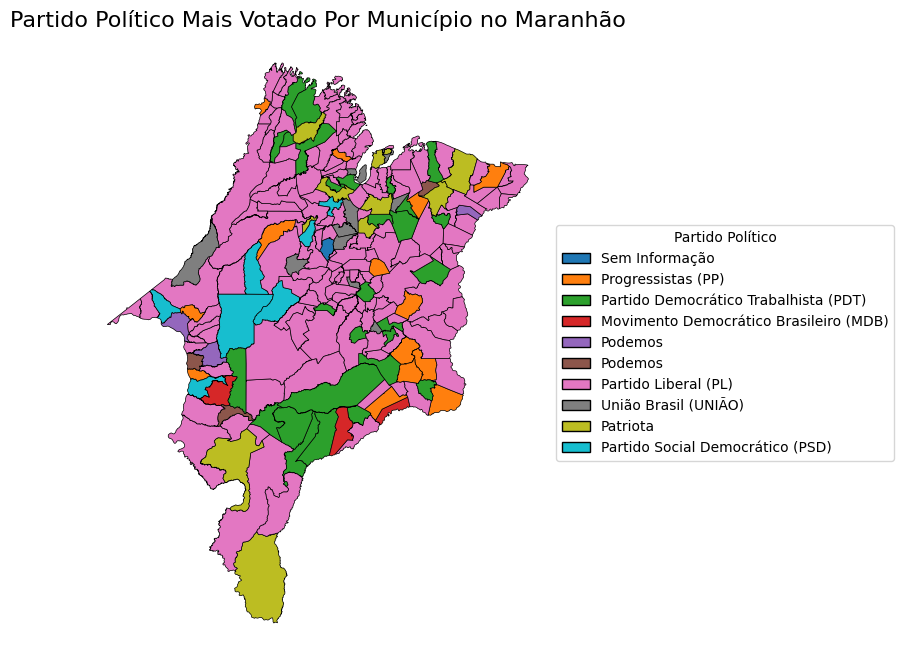

In [67]:
def plot_most_voted_party_map(df, shapefile_path):
    """
    Plota um mapa mostrando o partido político mais votado em cada município usando o DataFrame 'votacao_mun', considerando apenas os dois primeiros dígitos de 'NR_VOTAVEL'.

    Args:
        df: DataFrame contendo os dados de votação (votacao_mun).
        shapefile_path: Caminho para o shapefile contendo os limites dos municípios.
    """

    df['NR_PARTIDO'] = df['NR_VOTAVEL'].astype(str).str[:2].astype(int)

    most_voted_by_municipality = df.groupby('NM_MUN')['NR_PARTIDO'].agg(lambda x: x.value_counts().idxmax()).reset_index()

    gdf = gpd.read_file(shapefile_path)
    gdf['NM_MUN'] = gdf['NM_MUN'].str.upper().str.strip()

    most_voted_by_municipality['NM_MUN'] = most_voted_by_municipality['NM_MUN'].str.upper().str.strip()

    gdf = gdf.merge(most_voted_by_municipality, on='NM_MUN', how='left')

    gdf['NR_PARTIDO'] = gdf['NR_PARTIDO'].fillna(0)

    unique_parties = sorted(gdf['NR_PARTIDO'].unique())

    # Mapeia os números dos partidos para os nomes
    party_names = {
        11: "Progressistas (PP)",
        12: "Partido Democrático Trabalhista (PDT)",
        15: "Movimento Democrático Brasileiro (MDB)",
        19: "Podemos",
        20: "Podemos",
        22: "Partido Liberal (PL)",
        44: "União Brasil (UNIÃO)",
        51: "Patriota",
        55: "Partido Social Democrático (PSD)",
        0: "Sem Informação"
    }

    cmap = plt.colormaps['tab10']
    party_colors = {party: cmap(i / len(unique_parties)) for i, party in enumerate(unique_parties)}

    gdf['Party_Color'] = gdf['NR_PARTIDO'].map(party_colors)

    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    gdf.plot(color=gdf['Party_Color'], linewidth=0.5, edgecolor='black', ax=ax)

    ax.set_title('Partido Político Mais Votado Por Município no Maranhão', fontsize=16)
    ax.axis('off')

    legend_elements = [Patch(facecolor=party_colors[party], edgecolor='black', label=party_names.get(party, "Desconhecido"))
                       for party in unique_parties]
    ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5), title="Partido Político")

    plt.show()

plot_most_voted_party_map(votacao_mun, maranhao_shapefile)

## Análise extra

In [69]:
nota_fiscal = pd.read_csv('nota_fiscal_candidato_2022_MA.csv', sep=';', encoding='latin1')

nota_fiscal = nota_fiscal.rename(columns={'NM_URNA': 'NM_VOTAVEL'})
nota_fiscal = nota_fiscal.rename(columns={'NR_CANDIDATO': 'NR_VOTAVEL'})
nota_fiscal

,DT_GERACAO,HH_GERACAO,NR_ANO_REFERENCIA,CD_ELEICAO,NM_VOTAVEL,NR_VOTAVEL,SG_UF_UA,SG_UE,NM_UE_UA,CONTRATANTE,NR_CPF_CNPJ_EMITENTE,CD_NATUREZA_OPERACAO,CD_MODELO,NM_UNIDADE_ARRECADADORA,DT_EMISSAO,NR_NOTA_FISCAL,NR_SERIE,VR_NOTA_FISCAL,NR_CHAVE_ACESSO,NM_URL_ACESSO
0,26/12/2023,12:02:27,2022,546,PARÁ FIGUEIREDO,22111,MA,MA,MARANHÃO,Titular,13090943000102,VEND,55,SECRETARIA DA FAZENDA DO ESTADO DO MARANHÃO,0022-09-14 00:00:00,774,001,4900.00,0000002122091309094300010255001000000774154681...,http://www.nfe.fazenda.gov.br/portal/consultaR...
1,26/12/2023,12:02:27,2022,546,PASTOR CAVALCANTE,5522,MA,MA,MARANHÃO,Titular,4496308000120,VEND,55,SECRETARIA DA FAZENDA DO ESTADO DO MARANHÃO,0022-09-06 00:00:00,2120,001,161450.00,0000002122090449630800012055001000002120164225...,http://www.nfe.fazenda.gov.br/portal/consultaR...
2,26/12/2023,12:02:27,2022,546,PASTOR CAVALCANTE,5522,MA,MA,MARANHÃO,Titular,31379339000174,VEND,55,SECRETARIA DA FAZENDA DO ESTADO DO MARANHÃO,0022-09-30 00:00:00,2030,002,1467.90,0000002122093137933900017455002000002030133902...,http://www.nfe.fazenda.gov.br/portal/consultaR...
3,26/12/2023,12:02:27,2022,546,PASTOR CAVALCANTE,5522,MA,MA,MARANHÃO,Titular,31379339000174,VEND,55,SECRETARIA DA FAZENDA DO ESTADO DO MARANHÃO,0022-09-30 00:00:00,2031,002,1467.90,0000002122093137933900017455002000002031193625...,http://www.nfe.fazenda.gov.br/portal/consultaR...
4,26/12/2023,12:02:27,2022,546,CÉLIO REI DO CAVALO,36777,MA,MA,MARANHÃO,Titular,4496308000120,VEND,55,SECRETARIA DA FAZENDA DO ESTADO DO MARANHÃO,0022-09-29 00:00:00,2170,001,1000.00,0000002122090449630800012055001000002170107842...,http://www.nfe.fazenda.gov.br/portal/consultaR...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5772,26/12/2023,12:02:27,2022,546,CLAUDIA COUTINHO,12345,MA,MA,MARANHÃO,Titular,3855719000100,VEND,55,SECRETARIA DA FAZENDA DO ESTADO DO MARANHÃO,0022-10-01 00:00:00,15669,001,7038.24,0000002122100385571900010055001000015669122076...,http://www.nfe.fazenda.gov.br/portal/consultaR...
5773,26/12/2023,12:02:27,2022,546,CLAUDIA COUTINHO,12345,MA,MA,TIMON,Titular,3861181000139,SERV,00,PREFEITURA MUNICIPAL DE TIMON,0022-09-21 00:00:00,1380,002,17200.00,QHMO14RHV,http://45.184.25.2:8080/issweb/formGerarNF.jsf...
5774,26/12/2023,12:02:27,2022,546,CLAUDIA COUTINHO,12345,MA,MA,MARANHÃO,Titular,30523175000144,VEND,55,SECRETARIA DA FAZENDA DO ESTADO DO MARANHÃO,0022-09-09 00:00:00,36,001,6811.20,0000002122093052317500014455001000000036180194...,http://www.nfe.fazenda.gov.br/portal/consultaR...
5775,26/12/2023,12:02:27,2022,546,CLAUDIA COUTINHO,12345,MA,MA,MARANHÃO,Titular,3855719000100,VEND,55,SECRETARIA DA FAZENDA DO ESTADO DO MARANHÃO,0022-09-30 00:00:00,15651,001,6811.20,0000002122090385571900010055001000015651137482...,http://www.nfe.fazenda.gov.br/portal/consultaR...


In [85]:
nota_fiscal_candidato = nota_fiscal.groupby('NR_VOTAVEL')['VR_NOTA_FISCAL'].sum()

votacao_secao_candidato = votacao_mun_copy.groupby(['NR_VOTAVEL', 'NM_VOTAVEL'])['Total_Voto'].sum().reset_index()

candidatos = pd.merge(votacao_secao_candidato, nota_fiscal_candidato, on='NR_VOTAVEL', how='left')

candidatos['VOTOS_POR_REAL'] = candidatos['Total_Voto'] / candidatos['VR_NOTA_FISCAL']

candidatos = candidatos.sort_values('VR_NOTA_FISCAL', ascending=False)

In [86]:
votacao_secao_candidato

,NR_VOTAVEL,NM_VOTAVEL,Total_Voto
0,10,REPUBLICANOS,4499
1,11,PROGRESSISTAS,6196
2,12,Partido Democrático Trabalhista,15141
3,13,Partido dos Trabalhadores,18068
4,14,Partido Trabalhista Brasileiro,3934
...,...,...,...
366,9040,PAULO PEREIRA DA SILVA FILHO,195
367,9077,VASTY FRANCISCA DE MENESES,306
368,9087,EDÉSIO ARAÚJO DO NASCIMENTO,152
369,9090,ANTONIO FLAVIO MOTA CANDIDO,2664


In [87]:
candidatos_vr = candidatos[candidatos['VR_NOTA_FISCAL'] > 0]

candidatos_vr = candidatos_vr.reset_index()
candidatos_vr['NM_VOTAVEL'] = candidatos_vr['NR_VOTAVEL'].apply(lambda x: votacao_secao_candidato[votacao_secao_candidato['NR_VOTAVEL'] == x]['NM_VOTAVEL'].iloc[0])


Essa visualização é um scatter plot que relaciona os valores gastos pelos candidatos com a quantidade de votos recebidos, ambos em escala logarítmica. O uso da escala logarítmica é útil para lidar com as diferenças de magnitude nos dados e identificar padrões mais claramente. A cor dos pontos indica a eficiência do gasto, medida em votos por real gasto.

1. Análise Geral
* Eixo X (Valor Gasto): Representa o valor total gasto pelos candidatos, em escala logarítmica.
* Eixo Y (Quantidade de Votos): Representa a quantidade de votos recebidos, também em escala logarítmica.
* Cores: O gradiente de cores reflete a eficiência do gasto (votos por real), variando de roxo (baixa eficiência) a amarelo (alta eficiência).

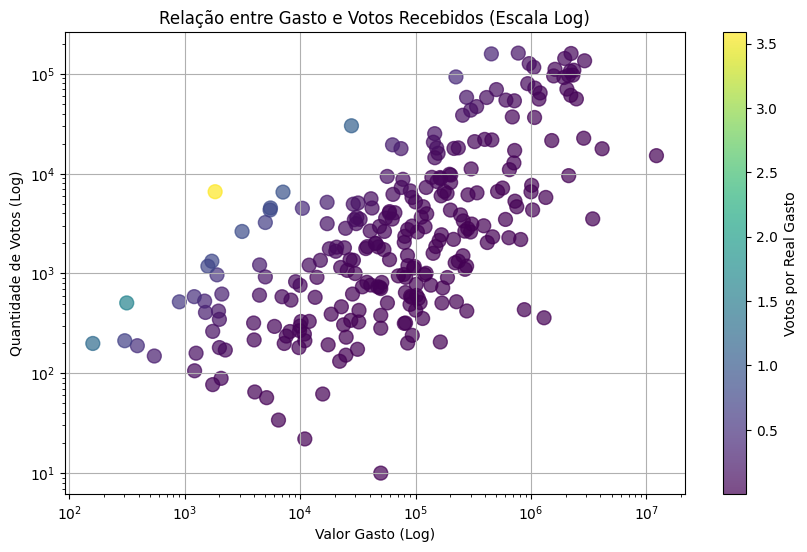

In [89]:
plt.figure(figsize=(10, 6))
plt.scatter(candidatos_vr['VR_NOTA_FISCAL'], candidatos_vr['Total_Voto'], c=candidatos_vr['VOTOS_POR_REAL'], cmap='viridis', s=100, alpha=0.7)
plt.xscale('log')
plt.yscale('log')
plt.colorbar(label='Votos por Real Gasto')
plt.title('Relação entre Gasto e Votos Recebidos (Escala Log)')
plt.xlabel('Valor Gasto (Log)')
plt.ylabel('Quantidade de Votos (Log)')
plt.grid(True)
plt.show()

### 1- Relação Geral Entre Gasto e Votos
Existe uma tendência positiva clara: candidatos que gastaram mais geralmente receberam mais votos.
No entanto, há variação significativa:
Alguns candidatos com gastos semelhantes têm resultados muito diferentes em termos de votos recebidos.
Isso indica que o gasto é um fator importante, mas não o único determinante.

### 2- Eficiência do Gasto
Alta eficiência (amarelo):
* Alguns pontos amarelos aparecem em regiões de baixo gasto e votos razoáveis, indicando campanhas extremamente eficientes.
* Esses candidatos podem ter usado estratégias de baixo custo, como redes sociais ou engajamento direto com eleitores.

Baixa eficiência (roxo):
* Muitos candidatos com gastos elevados (à direita) apresentam eficiência relativamente baixa, indicando que altos investimentos nem sempre resultam em votos proporcionais.

### 3- Outliers
Alguns candidatos se destacam como outliers:
* Candidatos com votos muito acima da média para um determinado gasto.
* Candidatos com gastos muito acima da média para uma quantidade de votos relativamente baixa.

Esses outliers podem ser explicados por fatores como popularidade, apoio partidário, estratégias de campanha ou eventos específicos.
